## Storm Tracking in the Caribbean 

### By Carolyn Davis, Germain Cohort

### 10/14/2021

The goal of this project was to develop an individual data science project that worked through all steps of the Data Science Pipeline. The data analysed in this project went through the necessary stages of Planning, Acquiring, Preparing, Exploration, and Modeling. 
- In this project you will use the Atlantic data provided by the HURDAT database, specifically longitudinal and     latitudinal coordinates for the Caribbean region in the Atlantic.

- You will perform all stages of the Data Science Pipeline in your analysis of the max wind speed in correlation with the number of hurricanes and tropical storms that have occcured historically.

- Patterns observed in the historical data will then be reviewed then utilized to develop models that forecast predictions for future hurricane occurrence in the designated region.

### Project Planning:
1. Identifed a region of interest, the Caribbean, within the Atlantic dataset provided by Kaggle.com via the  National Hurricane center.
2. Carribean data is acquired
3. Explore the unclean data to determine data preparation needs
4. Data is cleaned and split into train, validate, and test for exploration 
5. Explore on the training dataset
6. Look at the seasonal trends for the data via various plotting methods: Lag, Auto-correlation, and Seasonal Decomposition
7. Pick and build atleast 3 models that support accurate future predictions on dataset
8. Assess performance of the models based off the RMSE, ensuring model support compataibility with the analysed dataset
9. Ensure takeaways at steps of the performed in the Data Science pipeline ensuring second party recreation
10. Provide final conclusions, and recommendation following the completion of the model evalutions.

### Imports Utilized

In [1]:
#Imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as t
from dateutil import parser
import warnings
warnings.filterwarnings("ignore")

#import functions for carrib_data
import wranglecaribbean as wc

# visualize 
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# for fbprophet modeling
from fbprophet import Prophet
from sklearn.metrics import r2_score
import math

Importing plotly failed. Interactive plots will not work.


## ACQUIRING THE DATA

- You will acquire the data from the atlantic.csv in the zip file for Hurricanes and Typhoons, 1851-2014 dataset

In [2]:
#Dowloaded data into CSV from Kaggle and saved to proj directory
df = pd.read_csv('atlantic.csv')


#After a Quick Scan of the data:
#Filtering down to only look at data for storms since 1900
collector =[]

for date in df['Date']:
    if date > 19000000:
        collector.append(True)
    else: 
        collector.append(False)
date_range = pd.Series(collector)
new_df = df[date_range]


### Quick Look at the Data

In [3]:
#Getting a brief look at the data
new_df.shape

new_df.describe().T

#check for null values in the dataset
new_df.isnull().sum()

ID                  0
Name                0
Date                0
Time                0
Event               0
Status              0
Latitude            0
Longitude           0
Maximum Wind        0
Minimum Pressure    0
Low Wind NE         0
Low Wind SE         0
Low Wind SW         0
Low Wind NW         0
Moderate Wind NE    0
Moderate Wind SE    0
Moderate Wind SW    0
Moderate Wind NW    0
High Wind NE        0
High Wind SE        0
High Wind SW        0
High Wind NW        0
dtype: int64

## Data Preparation 

#### Removing Cardinal Letters 

In [4]:
#Removing cardinal letters from the lat and long columns 
new_df = new_df.replace({'N':''}, regex=True)
new_df = new_df.replace({'W':''}, regex=True)
new_df = new_df.replace({'E':''}, regex=True)
new_df = new_df.replace({'S':''}, regex=True)


In [5]:
#drop unnecessary columns 
new_df = new_df.drop(columns=['ID', 'Event', 'Minimum Pressure'], axis =1)


#### Renaming Columns for Readibility

In [6]:
new_df = new_df.rename(columns={'Name': 'name', 'Time': 'time', 'Status': 'status', 'Latitude': 'latitude',
                                'Longitude': 'longitude', 'Maximum Wind': 'max_wind', 'Low Wind NE': 'low_wind_NE',
                                'Low Wind SE': 'low_wind_SE', 'Low Wind SW': 'low_wind_SW', 'Low Wind NW': 'low_wind_NW',
                                'Moderate Wind NE': 'mod_wind_NE', 'Moderate Wind SE': 'mod_wind_SE',
                                'Moderate Wind SW': 'mod_wind_SW', 'Moderate Wind NW': 'mod_wind_NW',
                                'High Wind NE': 'high_wind_NE', 'High Wind SE': 'high_wind_SE', 'High Wind SW': 'high_wind_SW',
                                'High Wind NW': 'high_wind_NW'})


In [7]:
#converting Latitude and Longitude to floats:
new_df['latitude'] = new_df['latitude'].astype(float)
new_df['longitude'] = new_df['longitude'].astype(float)

In [8]:
#filtering outside latitudes to get desired Caribbean location for hurricane data
lat_filtered = new_df[(new_df['latitude'].astype(float) >= float(9)) & (new_df['latitude'].astype(float) <= float(26))]
lat_filtered.shape

(19720, 19)

#### Cleaning Up Cardinal Coordinates

In [9]:
#filtering out longitude by coordinate
#convert longitude to negative
lat_filtered['longitude'] = (lat_filtered['longitude'] * -1)
lat_long_filtered = lat_filtered[(lat_filtered['longitude'] >= -86) & (lat_filtered['longitude'] <= float(-56))]
print(lat_long_filtered.shape)

(9981, 19)


### Null Values
With reference to domain knowledge for this data set, it was found that the null values for this dataset are represented in the form of -999. Here the nulls are converted to string format for conversion to NaN, so that the potential for removal or imputation may be performed in the future.

In [10]:
weather_nulls = ['max_wind', 'low_wind_NE', 'low_wind_SE',
        'low_wind_SW', 'low_wind_NW', 'mod_wind_NE', 'mod_wind_SE', 'mod_wind_SW',
        'mod_wind_NW', 'high_wind_NE', 'high_wind_SE', 'high_wind_SW', 'high_wind_NW']


#Converting all data to strings so can be searched
 # Creates list of all column headers
lat_long_filtered[weather_nulls] = lat_long_filtered[weather_nulls].astype(str)

lat_long_filtered.info()   #all strings good to go 


#Converting all '-999' null values to 'NaN' which Python can automatically remove:
lat_long_filtered = lat_long_filtered.replace('-999', np.nan)

#the year 1967 has '-99' as maximum wind speed values - these must also be changed...dirty data
lat_long_filtered= lat_long_filtered.replace('-99', np.nan)

#double checking it worked like it should:
lat_long_filtered.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9981 entries, 9240 to 49089
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          9981 non-null   object 
 1   Date          9981 non-null   int64  
 2   time          9981 non-null   int64  
 3   status        9981 non-null   object 
 4   latitude      9981 non-null   float64
 5   longitude     9981 non-null   float64
 6   max_wind      9981 non-null   object 
 7   low_wind_NE   9981 non-null   object 
 8   low_wind_SE   9981 non-null   object 
 9   low_wind_SW   9981 non-null   object 
 10  low_wind_NW   9981 non-null   object 
 11  mod_wind_NE   9981 non-null   object 
 12  mod_wind_SE   9981 non-null   object 
 13  mod_wind_SW   9981 non-null   object 
 14  mod_wind_NW   9981 non-null   object 
 15  high_wind_NE  9981 non-null   object 
 16  high_wind_SE  9981 non-null   object 
 17  high_wind_SW  9981 non-null   object 
 18  high_wind_NW  9981 non-n

name               0
Date               0
time               0
status             0
latitude           0
longitude          0
max_wind          41
low_wind_NE     8632
low_wind_SE     8632
low_wind_SW     8632
low_wind_NW     8632
mod_wind_NE     8632
mod_wind_SE     8632
mod_wind_SW     8632
mod_wind_NW     8632
high_wind_NE    8632
high_wind_SE    8632
high_wind_SW    8632
high_wind_NW    8632
dtype: int64

In [11]:
#Fixing the date format issues found in the data
lat_long_filtered = wc.date_fix(lat_long_filtered)

### Takeaways:
- Based off the data there are just too many null values in the low wind, modwind, and high wind columns.
  I am have decided to drop these. The max_wind provides interest for further exploration as well the status, month,  and year cols forthis project analysis

In [12]:
#drop unnecessary columns 
clean_df  = lat_long_filtered.drop(columns=['low_wind_NE', 'low_wind_SE',
        'low_wind_SW', 'low_wind_NW', 'mod_wind_NE', 'mod_wind_SE', 'mod_wind_SW',
        'mod_wind_NW', 'high_wind_NE', 'high_wind_SE', 'high_wind_SW', 'high_wind_NW', 'time'], axis =1) 
 

In [13]:
# Setting the index to the datetime for exploration


clean_df = clean_df.set_index('Date')

In [14]:

clean_df['max_wind'] = clean_df['max_wind'].astype(float) 
clean_df = clean_df.sort_values(by='max_wind', ascending=False)

In [15]:
clean_df = wc.name_fixer(clean_df, 'name')
clean_df = wc.name_fixer(clean_df, 'status')




In [16]:
#this function removes the whitespace found in the data columns for ['status'] but also removes all other occurrences
clean_df = wc.whitespace(clean_df)

In [17]:
storms = clean_df['status'].value_counts()

def get_storms(storm_df):
    '''
    This function will create dummy variables out of the original status column.
    It takes in the df column and converts the status types to booleans.
    '''
    # create dummy vars of storms id
    storm_df = pd.get_dummies(storm_df.status)
    # rename columns by actual county name
    storm_df.columns = ['T', 'HU', 'TD', 'LO', 'V', 'DB', 'X', 'D']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    storm_df = pd.concat([clean_df, storm_df], axis = 1)
    # drop  status columns
    # df = df.drop(columns = ['status'])
    return storm_df

clean_df = get_storms(clean_df)

In [18]:
clean_df = clean_df.sort_index()

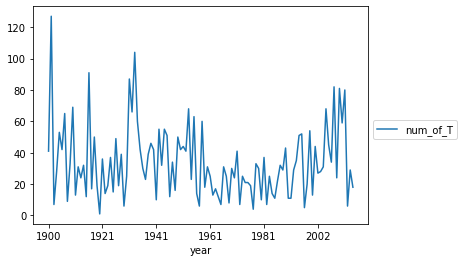

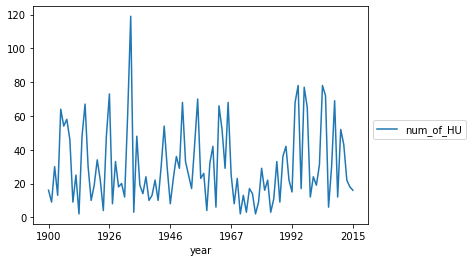

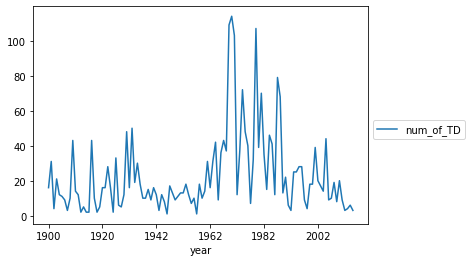

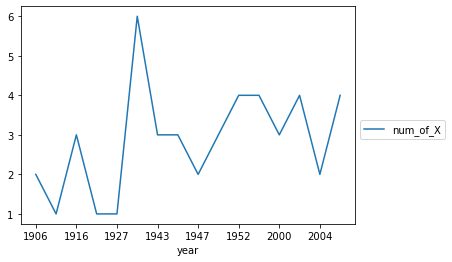

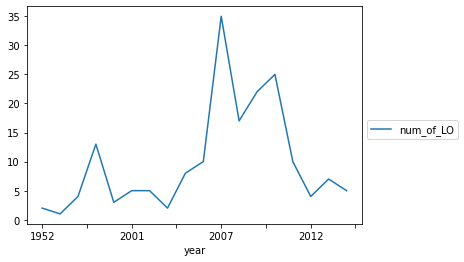

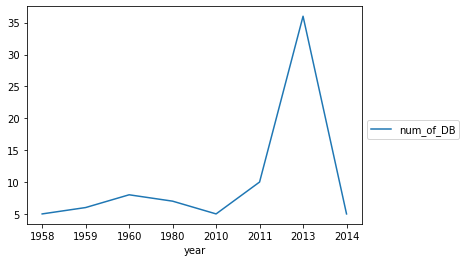

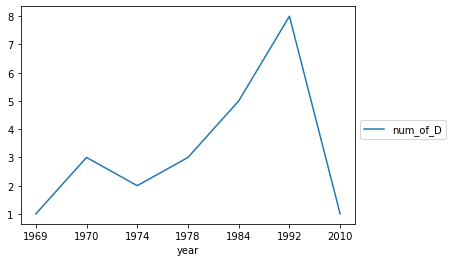

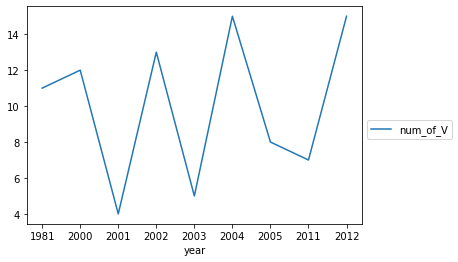

In [19]:
types = clean_df["status"].unique()
def storm_freq_analysis(data, storm):
    storms = data[data["status"] == storm]
    storms.loc[:, "ones"] = 1
    storms.groupby("year")["ones"].sum().plot(label=f"num_of_{storm}")
    plt.legend(bbox_to_anchor=(1.0, 0.5))
    plt.show()
    plt.close()
    
    return storms

storm_freq_collector = {}
for storm in types:
    storm_freq_collector[storm] = storm_freq_analysis(clean_df, str(storm))

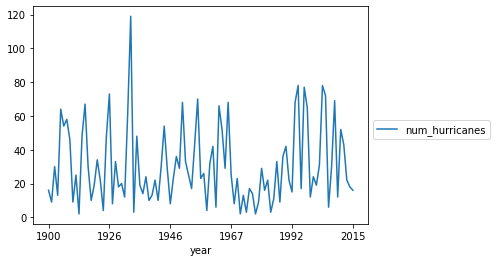

In [20]:
# number of hurricanes
hurricanes = clean_df[clean_df["status"] == "HU"]
hurricanes.loc[:, "ones"] = 1
hurricanes.groupby("year")["ones"].sum().plot(label="num_hurricanes")
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()
plt.close()

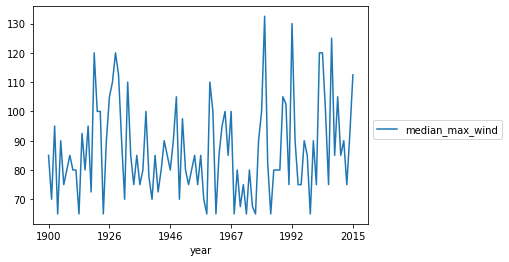

In [21]:
# intensity of hurricanes
hurricanes.groupby('year')['max_wind'].median().plot(label='median_max_wind')
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()
plt.close()

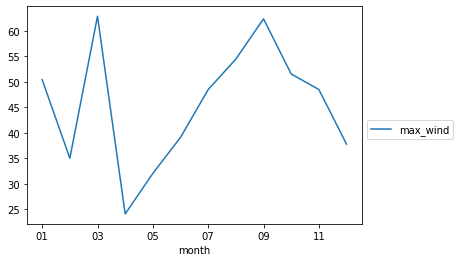

In [22]:
#how does average number of storms change over over months?
clean_df.groupby('month')['max_wind'].mean().plot(label='max_wind')
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()
plt.close()
#Takeaway: Can you guess when hurricane/tropical storm season is?

### TAKEAWAYS:
- Median max wind appears to be increasing pretty steadily in the last 115 years 
- Similarly the number of hurricanes appears to be increasing on average each year as well.
- Other types of storms such as extratropical cyclones, tropical cycloses, and depression seem to provide fairly consistent behavior in the last 25 years of the period analyzed 


### MOVING FORWARD: 
There is a clear trend seen in the increased prevalence of hurricanes in the last 115 years and the increase of median wind speed. Hurricanes are defined as storms with wind speeds in the range of 50 t0 157+ knots. Since I am really curious in these storms that do the most damage, I will move forward only looking at hurricane prevalence and date. 

### Splitting the Data: Train, Validate, Test

In [23]:
#Only going to look at the date, and max_wind for hurricanes in the last 115 years
hurdat = hurricanes[['max_wind']] 

In [24]:
#50% of the hurricane data goes to train
train_size = int(len(hurdat)*0.5)

In [25]:
#30% of the hurricane data goes to validate
validate_size = int(len(hurdat)*0.3)

In [26]:
#20% of the hurricane data goes to test
test_size = int(len(hurdat)-train_size - validate_size)

In [27]:
#establishing that the end of the validate set is the length of train size and validate size combined
validate_end_index = train_size + validate_size

In [28]:
#train
train = hurdat[:train_size]
#validate
validate = hurdat[train_size:validate_end_index]
#test
test = hurdat[validate_end_index:]

In [29]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(hurdat))

True


### Preparing the Data for Visualization

In [30]:
#make copy of the original train dataset
train_hurdat = train.copy()
train_hurdat.index = pd.DatetimeIndex(train.index)

validate_hurdat = validate.copy()
validate_hurdat.index = pd.DatetimeIndex(validate.index)


test_hurdat = test.copy()
test_hurdat.index = pd.DatetimeIndex(test.index)


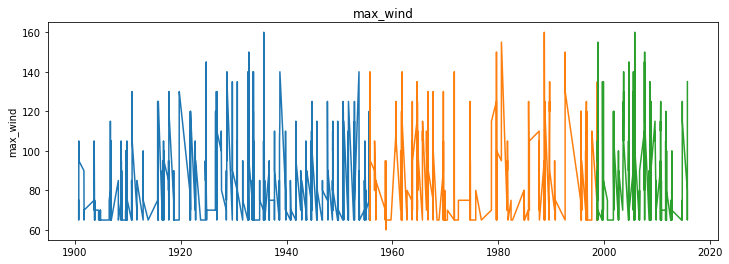

In [31]:
#let's have a look at our data and its splits
for col in train_hurdat.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train_hurdat[col])
    plt.plot(validate_hurdat[col])
    plt.plot(test_hurdat[col])
    
    plt.ylabel(col)
    plt.title(col)

## Exploration 

In [32]:
train_hurdat = pd.DataFrame(train_hurdat["max_wind"].resample("Y").median().dropna())

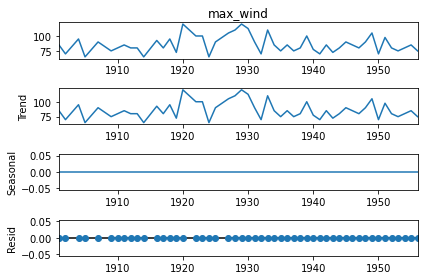

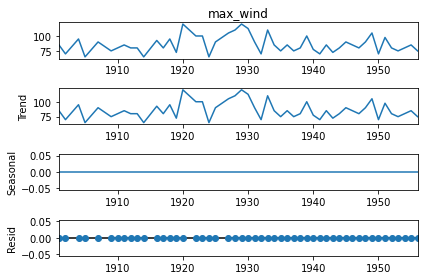

In [33]:
#seasonal decomposition - 1 year
seasonal = sm.tsa.seasonal_decompose(train_hurdat["max_wind"], model="additive", period=1)
seasonal.plot()

In [34]:
#Lets loook some more at the max_wind speed in the train_hurdat dataset 
y = train_hurdat.max_wind

<AxesSubplot:xlabel='Date'>

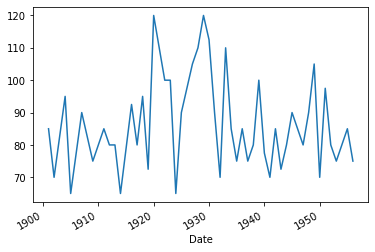

In [35]:
#Visualizing max_wind in the train_hurdat data set
y.plot()

<AxesSubplot:xlabel='Date'>

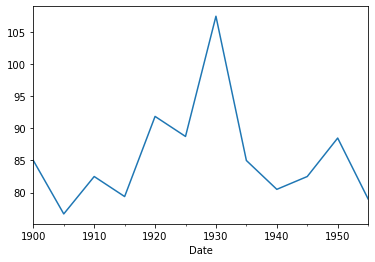

In [36]:
y.resample('5Y').mean().plot()
#we see a spike in hurricane max_wind speed 

<AxesSubplot:xlabel='Date'>

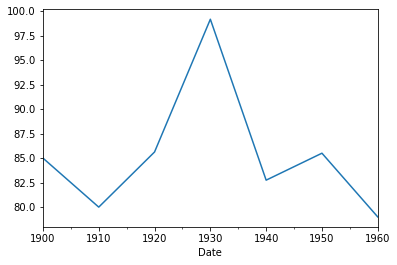

In [37]:
y.resample('10Y').mean().plot()
#max_wind for hurricanes over decades is supportive of five year increments

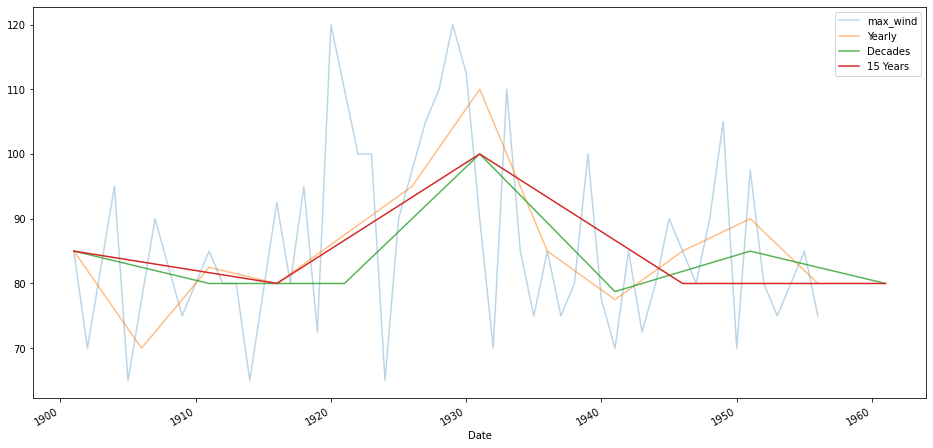

In [38]:
#average max_wind speeds for hurricanesacross various time periods
plt.figure(figsize=(16,8))
ax = y.plot(alpha=.3)
y.resample('5Y').median().plot(ax=ax, alpha=.5, label='Yearly')
y.resample('10Y').median().plot(ax=ax, alpha=.8, label='Decades')
y.resample('15Y').median().plot(ax=ax, label='15 Years')
ax.legend()
plt.show()

[Text(0.5, 1.0, 'Max_wind Hurricane Speeds Over Year'),
 Text(0.5, 17.897709267877563, 'Year'),
 Text(77.875, 0.5, 'max_wind speed')]

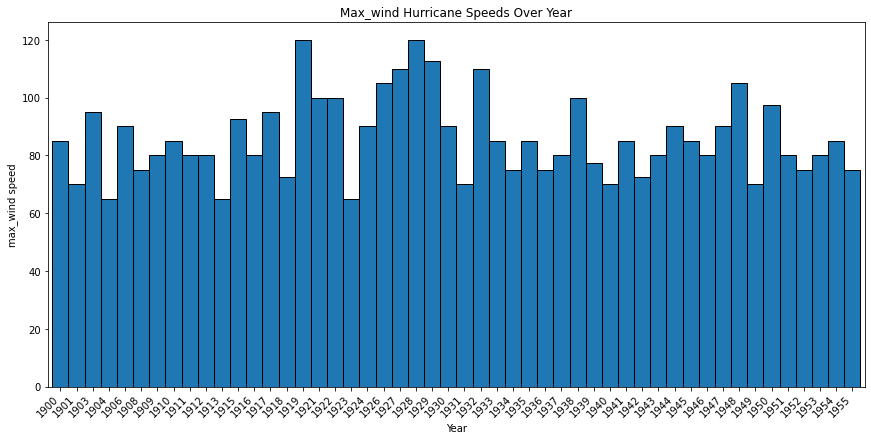

In [39]:
y.index = pd.DatetimeIndex(y.index)

#average max_wind speed by year but in a bar chart.
ax = y.groupby(y.index.year).median().plot.bar(width=1,ec='black', figsize=(12, 6))
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
ax.set(title='Max_wind Hurricane Speeds Over Year', xlabel='Year',ylabel='max_wind speed')

## LAG PLOT
This is a scatter plot that will plot measures of one value again the next or previous value. The time periods looked at in this plot will be over a year range (t+1).

[Text(0.5, 0, 't'), Text(0, 0.5, 't+1')]

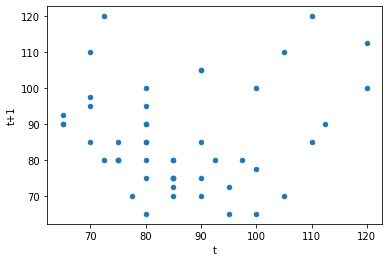

In [40]:
#How does the Hurdat max_wind data project 1 year out?
#pd.plotting.lag_plot(y.resample('Y').median(), 1)


train_hurdat['y(t+1)']=train_hurdat.max_wind.shift(-1)
ax=train_hurdat.plot.scatter(x='max_wind', y='y(t+1)')
ax.set(xlabel='t',ylabel='t+1')

As suspected, this data is not sufficient enough for predictions one year out.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 5)'>

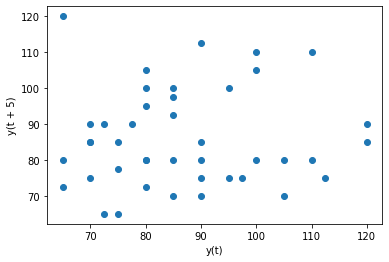

In [41]:
#How does the Hurdat max_wind data project 5 year out?
pd.plotting.lag_plot(y.resample('Y').median(), 5)

A little better...

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 10)'>

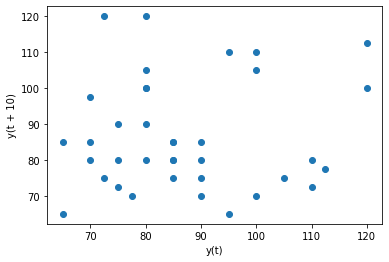

In [42]:
#How does the Hurdat max_wind data project 10 years out?
pd.plotting.lag_plot(y.resample('Y').median(), 10)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 15)'>

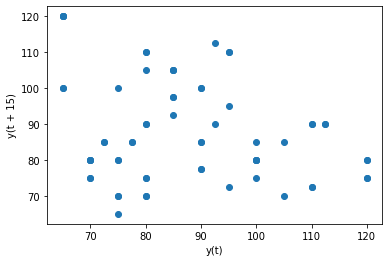

In [43]:
#How does the Hurdat max_wind data project 15 years out?
pd.plotting.lag_plot(train_hurdat.resample('Y').median(), 15)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 20)'>

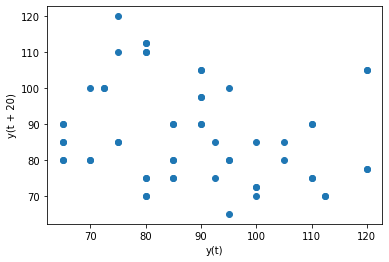

In [44]:
#How does the Hurdat max_wind data project 20 years out?
pd.plotting.lag_plot(train_hurdat.resample('Y').median(), 20)

## Autocorrelation Plot 
This plot aids identyin seasonality by looking at the peaks and valleys of the resulting visualization

In [45]:
def correlation(y, lag):
    return pd.concat([y, y.shift(lag)], axis=1).dropna().corr().iloc[0, 1]


autocorr = pd.Series({lag: correlation(y.resample('Y').mean(), lag) for lag in range(1, 10)})
autocorr

1    0.102183
2    0.171626
3    0.232897
4   -0.044739
5    0.056893
6    0.035030
7    0.079881
8   -0.061998
9    0.108697
dtype: float64

The Autocorrelation plot for the data is:


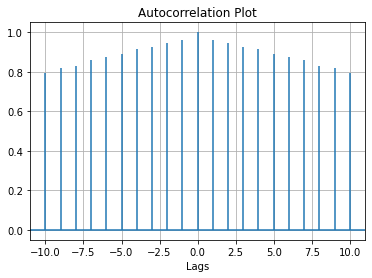

In [46]:
# Data for which we plot Autocorrelation.
data = train_hurdat['max_wind']
   
# Adding plot title.
plt.title("Autocorrelation Plot")
 
# Providing x-axis name.
plt.xlabel("Lags")
 
# Plotting the Autocorrelation plot.
plt.acorr(data, maxlags = 10)
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show()

In [47]:
#ensure that you drop the lag plot data from train_hurdat
train_hurdat = train_hurdat.drop(columns = ['y(t+1)'])

In [48]:
#Check out the data to confirm removal of column
train_hurdat

,max_wind
Date,
1900-12-31,85.0
1901-12-31,70.0
1903-12-31,95.0
1904-12-31,65.0
1906-12-31,90.0
1908-12-31,75.0
1909-12-31,80.0
1910-12-31,85.0
1911-12-31,80.0


## Takeaways from Exploration:
- Consistent trend over time, appears to be several cycles throughout the presented year period
- It is apparent that it is easier to identify trends over longer periods of time 
- There is a clear increase in prevalency in hurricane activity for the time period visualized.
- Seasonality plots with tsa indicate possible issues with models that do not support nonlinear data.

## Moving Forward:
- Models for linear data will be tested, if performance indicates noncompatibility with the data, nonlinear models will be explored and tested for potential for better compatibility with the data.

# Modeling
- Several of the functions utlized in this phase can also be referenced in the caribb-funcs.py file.
- The models tested in this phase include the 'Last Observed Value, Simple Average, Moving Average, and finally the Prophet model' after certain observations were made with the performance of models as executed.

In [49]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate_hurdat[target_var], yhat_df[target_var])), 0)
    return rmse


def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train_hurdat[target_var], label='Train', linewidth=1)
    plt.plot(validate_hurdat[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    '''
    make a prediction column
    '''
    yhat_df = pd.DataFrame({'max_wind': [temp]},  
                      index = validate_hurdat.index)

    return yhat_df

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train_hurdat[target_var], label='train')
    plt.plot(validate_hurdat[target_var], label='validate')
    plt.plot(test_hurdat[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [50]:
# create an empty dataframe to store model type, our avg_temp, and its rmse.
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


## Last Observed Value:
This is the easiest way to forecast and predict all future values to be the last observed value.

In [51]:
temp = train_hurdat['max_wind'][-1:][0]
temp

75.0

In [52]:
#Now make predictions based off the last observed value:
yhat_df = pd.DataFrame({'max_wind': [temp]},  
                      index = validate_hurdat.index)

yhat_df.head()

,max_wind
Date,
1955-09-15,75.0
1955-09-15,75.0
1955-09-15,75.0
1955-09-16,75.0
1955-09-16,75.0


max_wind -- RMSE: 27


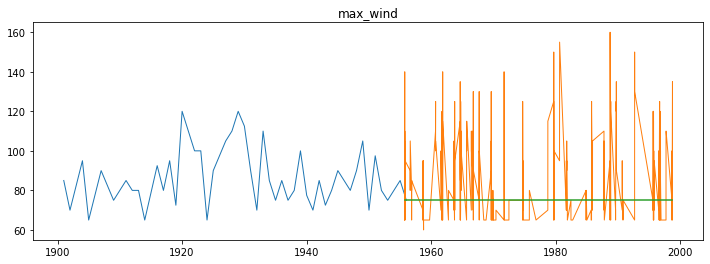

In [54]:
#Visualize the predictions for the last observed value:
plot_and_eval('max_wind')

In [55]:
#Now append these results to the eval_df that was created 
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,max_wind,27.0


## Simple Average
This takes the simple average of historical values and uses that value to predict future values. 

In [56]:
temp = round(train_hurdat['max_wind'].median(),2)
temp

85.0

In [57]:
#Now make predictions based off the Simple Average:
yhat_df = pd.DataFrame({'max_wind': [temp]},  
                      index = validate_hurdat.index)

yhat_df.head()

,max_wind
Date,
1955-09-15,85.0
1955-09-15,85.0
1955-09-15,85.0
1955-09-16,85.0
1955-09-16,85.0


max_wind -- RMSE: 22


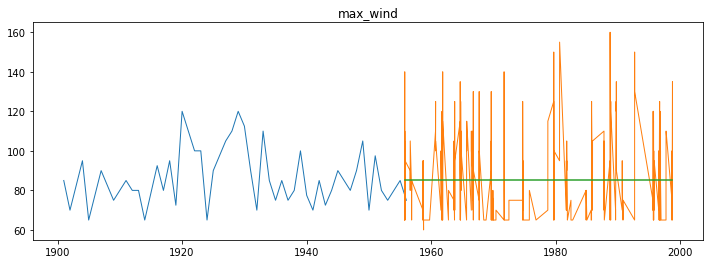

In [58]:
#Visualize the predictions based off the calculated Simple Average:
plot_and_eval('max_wind')

In [59]:
#Now append the results of this model to the eval_df we previously created:
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,max_wind,27.0
1,simple_average,max_wind,22.0


## Moving Average
The rolling average will be utilized to forecast predictions for periods of 1,5,10,15,20 year(s)

In [60]:
periods = [1, 5, 10, 15, 20]

for p in periods: 
    temp = round(train_hurdat['max_wind'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'year_moving_avg'
    for col in train_hurdat.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [61]:
#now call the eval_df and check out the results
eval_df

,model_type,target_var,rmse
0,last_observed_value,max_wind,27.0
1,simple_average,max_wind,22.0
2,1year_moving_avg,max_wind,27.0
3,5year_moving_avg,max_wind,25.0
4,10year_moving_avg,max_wind,23.0
5,15year_moving_avg,max_wind,23.0
6,20year_moving_avg,max_wind,23.0


In [62]:
#It appears that so far the Simple Average model is performing the best in comparison to the other models
min_temp_rmse = eval_df[eval_df.target_var=='max_wind']['rmse'].min()

eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
1,simple_average,max_wind,22.0


Simple Average seems to be the winner of all the model_types tested.

## Observations/Takeaways:
It is is apparent that with the models tested that the rmse for the target variable is not performing well because this data nonlinear. 
Moving forward, I will utilize the Prophet Model provided by importing fb_prophet to make future predictions past the the year 2015. Future predictions will be made to forecast hurricane activity for the year 2016.
This models seems like it would be best suited for the data and make the best predictions for future hurricane occurrences in the Caribbean

## Switching It Up: modeling with fbprophet
- This model supports the interaction on nonlinear data. The model will take in all of the max_wind data for the population that has been prepped and cleaned. It will then make predictions for occurrence of hurricanes in the Caribbean for the future year of 2016. 

In [63]:
#Copy the original prepped df with all max_wind speeds for all types of storms
wind_data = clean_df[['max_wind']].copy()




In [64]:
#reset the index 
wind_data = wind_data.reset_index()

#Rename the columns for input validation with fbprophet
wind_data = wind_data.rename(columns={'Date': 'ds', 'max_wind': 'y'})

In [65]:
#make the thing
model = Prophet(daily_seasonality=True)
#fit the thing
model.fit(wind_data)


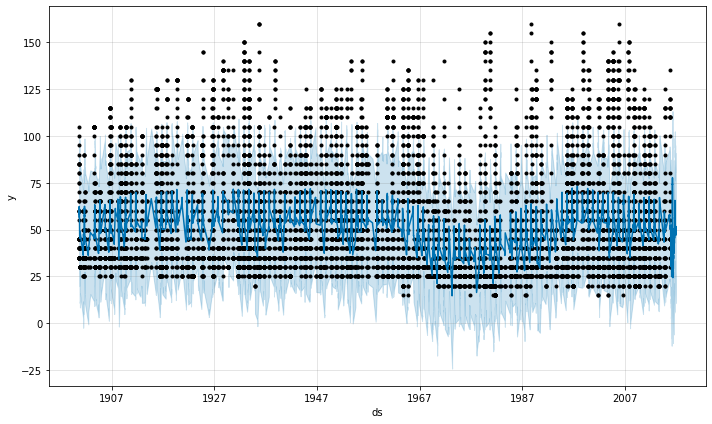

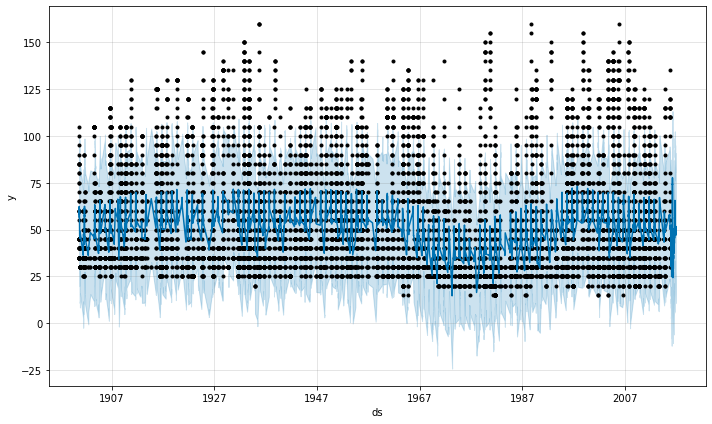

In [66]:
#Established 365 periods in a year, this will provide daily future predictions 
future = model.make_future_dataframe(periods=365)

#Assign what is to be predicted
prediction = model.predict(future)
#Assign the predictions for visualization
model.plot(prediction)

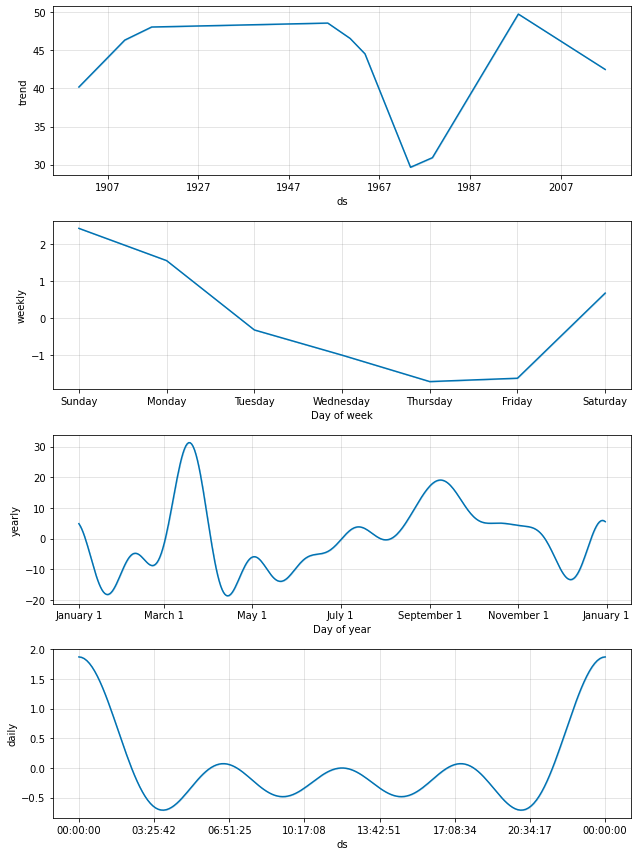

In [67]:
#Visualize those predictions 
model.plot_components(prediction)
plt.show()


#### Observations:
This model already seems to support the nature of the data better than the others built.It provides results that were not achieved with the previous models. It supports indication of seasonality and trend that was not made evident in the previous models. Moving forward with the predictions.

In [68]:
#Add the target variable to the predictions df 
prediction = pd.concat([prediction, wind_data['y']], axis=1)

#Notice the Naans in the Future predictions for arduous cols, drop those, we are only concered with the target's predictions
prediction = prediction.dropna()

In [71]:
#Let's see the rmse score for the Prophet model
r2 = r2_score(prediction['y'], prediction['yhat'])


mse = mean_squared_error(prediction['y'], prediction['yhat'])

prophet_rmse = math.sqrt(mse)


In [75]:
print(f'The RMSE for the Prophet model is: {prophet_rmse}')
print('-'*60)
print(eval_df)

The RMSE for the Prophet model is: 31.404388643467335
------------------------------------------------------------
            model_type target_var  rmse
0  last_observed_value   max_wind  27.0
1       simple_average   max_wind  22.0
2     1year_moving_avg   max_wind  27.0
3     5year_moving_avg   max_wind  25.0
4    10year_moving_avg   max_wind  23.0
5    15year_moving_avg   max_wind  23.0
6    20year_moving_avg   max_wind  23.0


### Takeaways:
- Though the Prophet model did not perform the best to forecast future storm predictions for the year 2017, it is apparent that this model proved most compatible with the Atlantic dataset. It is suggested that with further focus on feature exploration, the rmse provides potential for an increase in accuracy for future predictions.

## Conclusions:
- Following all the steps performed in the Data Science Pipeline, results indicate that max_wind appears to be a key driver of hurricane detection in the Caribbean region of the Atlantic Ocean
- Of the models developed and worked with, the fb_prophet model seems most ideal due to the characteristics of the Caribbean data being nonlinear.
- Due to the nature of making previous cycle predictions on the models tested prior to fb_prophet it is recommended to move forward analysing and testing on this data with models that support such nonlinear data.
- With more time, I would like to look possible seasonality produced by the fb_model. Additionally, it was apparent that by perhaps working with data after the year 1950, predictions for the fb_prophet would potentially prove to be more accurate. 
- It would be interesting to acquiring more recent data for this region from the National Hurricane database in order to make more real-time predicitions, as it is apparent that the rate of occurrence for hurricanes in particular is steadily rising.